In [1]:
import numpy as np
import torch 
import seaborn as sns
import cv2
import os
import pandas as pd
from tqdm.notebook import tqdm
from datetime import datetime
from time import time
import matplotlib.pyplot as plt
from utils import big_image_predict, imp_cont_img_file, preprocess_image
from mpl_toolkits import mplot3d

In [2]:
true_results = {
    5 : {
        1 : 1.48,
        2 : 2.74, 
        3 : 2.86,
        4 : 2.52,
        5 : 3.16,
        6 : 1.36,
        7 : 2.98,
        8 : 1.79,
        9 : 2.81,
        11 : 2.57,
        12 : 2.80,
        13 : 2.40,
        14 : 2.44,
        18 : 2.29,
        19 : 2.64,
        20 : 3.28,
    },
    16 : {
        1 : 1.94,
        2 : 1.89,
        3 : 2.89,
        4 : 2.62,
        5 : 1.12,
        6 : 3.86,
        7 : 2.72,
        8 : 2.84,
        9 : 2.37,
        10 : 0.29,
        11 : 2.14,
        12 : 3.17,
        13 : 3.04,
        14 : 2.94,
        15 : 2.40,
        16 : 2.35,
        17 : 3.09,
        18 : 2.80,
        19 : 2.38,
        20 : 0.22,
        21 : 1.01,
        22 : 4.36,
        23 : 2.64,
        24 : 1.83,
        25 : 2.50,
        26 : 2.44,
        27 : 2.31,
        28 : 2.68,
        29 : 2.96,
        30 : 0.15,
    }
}

In [3]:
path_05 = 'asbest/transporter/2020.03.05/'
path_16 = 'asbest/transporter/2020.03.16/'
files_05 = os.listdir(path_05)
files_16 = os.listdir(path_16)
files_05.sort()
files_16.sort()
files_05 = [file for file in files_05 if os.path.isfile(os.path.join(path_05, file))]
files_16 = [file for file in files_16 if os.path.isfile(os.path.join(path_16, file))]

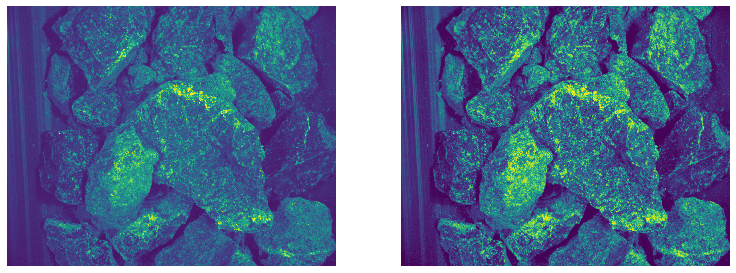

In [14]:
f = [file for file in files_05 if file.split('_')[0] == '1']
# np.random.randint(0,len(f))
image = cv2.imread(os.path.join(path_05, f[1]), cv2.IMREAD_UNCHANGED)
cont_image = imp_cont_img_file(os.path.join(path_05, f[0]), clip_limit=1.2)
# msk = big_image_predict(torch.load('stone_segmentation.pth'), image, crop_size = (image.shape[1] // 2, image.shape[0] // 2), inp_size = (448,448))
plt.figure(figsize=(20,12))
plt.subplot(131)
plt.axis('off')
plt.imshow(image)
plt.subplot(132)
plt.axis('off')
plt.imshow(cont_image)
# plt.subplot(133)
# plt.imshow(msk)

1_11:32:12_16-03-2020_1.png


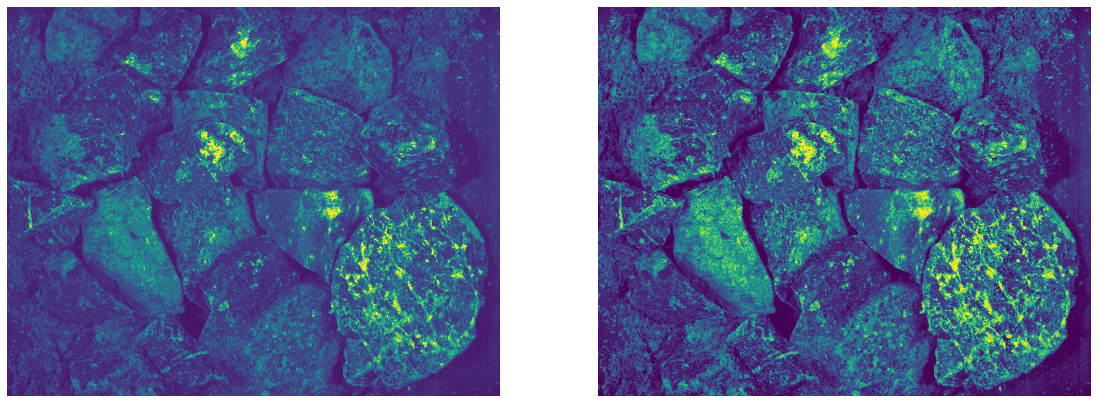

In [16]:
f = [file for file in files_16 if file.split('_')[0] == '1']
# np.random.randint(0,len(f))
print(f[1])
image = cv2.imread(os.path.join(path_16, f[1]), cv2.IMREAD_UNCHANGED)
cont_image = imp_cont_img_file(os.path.join(path_16, f[0]),clip_limit=1.2)
# msk = big_image_predict(torch.load('stone_segmentation.pth'), image, crop_size = (image.shape[1] // 2, image.shape[0] // 2), inp_size = (448,448))
plt.figure(figsize=(30,15))
plt.subplot(131)
plt.axis('off')
plt.imshow(image)
plt.subplot(132)
plt.axis('off')
plt.imshow(cont_image)
# plt.subplot(133)
# plt.imshow(msk)

In [329]:
def get_labels_var(labels, variance):
    new_labels = np.zeros(labels.shape, dtype=np.uint32)
    for label in np.unique(labels):
        label_points = np.where(labels == label)
        points = np.concatenate(label_points)
        points = points.reshape(2, 1, int(len(points) / 2)).T
#         rows,cols = img.shape[:2]
        [vy,vx,y,x] = cv2.fitLine(points, cv2.DIST_L2, 0, 0.01, 0.01)
        centred_points = np.squeeze(points - np.array([[y[0], x[0]]]))
        v = np.array([[vy[0], vx[0]]])
        ortog_points = centred_points - np.matmul(np.matmul(centred_points, v.T) / np.dot(v,v.T), v)
        var = np.mean(np.sqrt(np.sum(ortog_points * ortog_points, axis=1)))
        if variance >= var:
            new_labels[label_points] = label
    return new_labels

def get_labels_area(labels, stats, area):
    new_labels = np.zeros(labels.shape, dtype=np.uint32)
    for i, stat in enumerate(stats):
        if stat[-1] > area and i != 0:
            new_labels[np.where(labels == i)] = i
    return new_labels

def show_process_image(img, threshold, min_area, circle_coef):
    _, msk = big_image_predict(torch.load('stone_segmentation.pth'), img, crop_size = (img.shape[1] // 2, img.shape[0] // 2), inp_size = (448,448))
    plt.figure(figsize=(22,12))
    plt.subplot(231)
    plt.imshow(img)
    plt.subplot(232)
    plt.imshow(msk)
    plt.subplot(233)
    clahe = cv2.createCLAHE(clipLimit=1.2, tileGridSize=(8,8))
    img = clahe.apply(img).astype(float) / 255
    # img = cv2.GaussianBlur(img, ksize=(25, 25), sigmaX=5)
    plt.imshow(img)

    plt.subplot(234)
    bw = (img > threshold).astype(np.uint8)
    plt.imshow(bw)
    
    plt.subplot(235)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(7,7))
    bw = cv2.morphologyEx(bw, cv2.MORPH_CLOSE, kernel)
#     kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(9,9))
#     bw = cv2.morphologyEx(bw, cv2.MORPH_CLOSE, kernel)
    _, labels, stats, _ = cv2.connectedComponentsWithStats(bw, 8)
    labels = get_labels_area(labels, stats, 1000)
    plt.imshow(labels)
    
    plt.subplot(236)
    labels = get_labels_var(labels, 10)
    plt.imshow(labels)
#     cnts, hierarchy = cv2.findContours((bw).astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
#     big_cnts = []
#     for cnt in cnts:
#         area = cv2.contourArea(cnt)
#         _, radius = cv2.minEnclosingCircle(cnt)
#         if area > min_area and area / np.pi / radius ** 2 < circle_coef:
#             big_cnts.append(cnt)
#     bw = np.zeros(img.shape, dtype=np.uint8)
#     cv2.drawContours(bw, big_cnts, -1, 255, 5, 1)
#     plt.imshow(bw * (msk > 0.95))
    
    return labels, stats

30_13:46:56_16-03-2020_2.png


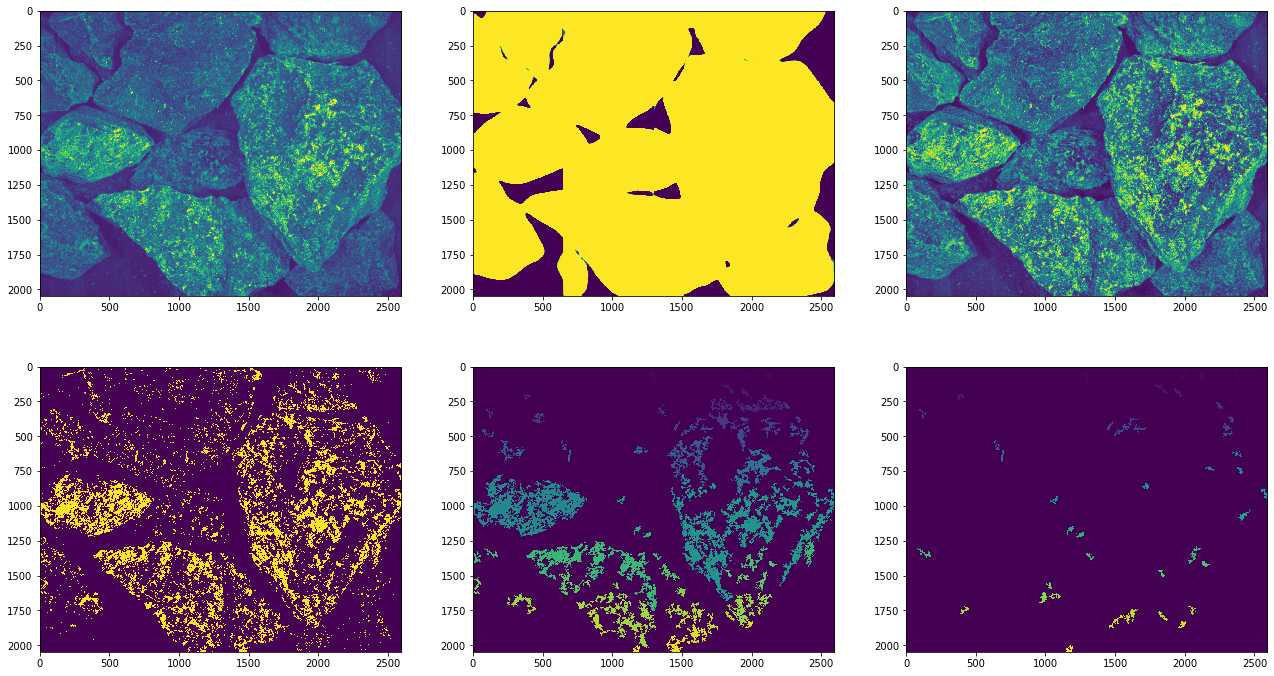

In [342]:
threshold = 0.6
min_area = 300
circle_coef = 0.25

i = np.random.randint(0, len(f))

f = [file for file in files_16 if file.split('_')[0] == '30']
print(f[i])
# np.random.randint(0,len(f))
img = cv2.imread(os.path.join(path_16, f[i]), cv2.IMREAD_UNCHANGED)
labels, stats = show_process_image(img, threshold, min_area, circle_coef)

In [281]:
indexes = []
for i, stat in enumerate(stats):
    if stat[-1] > 1000 and i != 0:
        indexes.append(i)
# img = labels == i
# plt.imshow(img)
len(indexes)

25

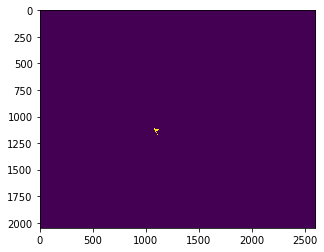

In [282]:
i = indexes[9]
img = labels == i
plt.imshow(img)

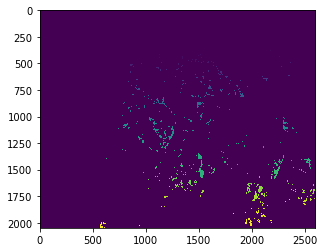

In [297]:
plt.imshow(get_labels_var(labels, 10))

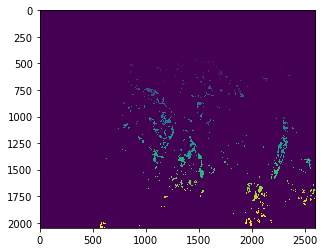

In [289]:
plt.imshow(labels)

In [283]:
points = np.where(img == True)
points = np.concatenate(points)
points = points.reshape(2, 1, int(len(points) / 2)).T
points.shape

(1137, 1, 2)

[array([0.2684359], dtype=float32), array([0.96329755], dtype=float32), array([1092.1407], dtype=float32), array([1134.1592], dtype=float32)]


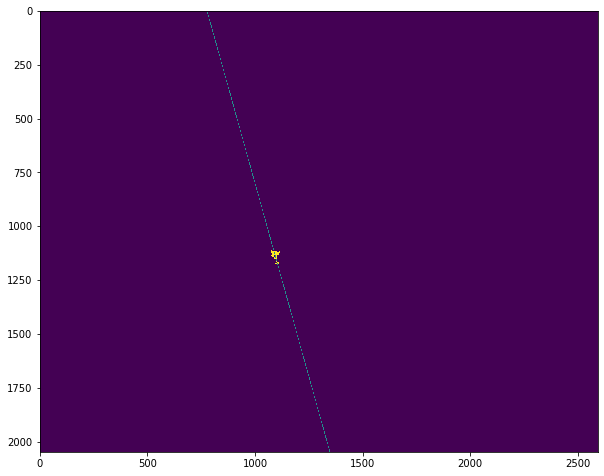

In [284]:
rows,cols = img.shape[:2]
[vy,vx,y,x] = cv2.fitLine(points, cv2.DIST_L2, 0, 0.01, 0.01)
print([vx,vy,x,y])
lefty = int((-x*vy/vx) + y)
righty = int(((cols-x)*vy/vx)+y)
img = cv2.line(img.astype(np.uint8) * 255,(cols-1,righty),(0,lefty),128,2)
plt.figure(figsize=(10,10))
plt.imshow(img)

In [285]:
centred_points = np.squeeze(points - np.array([[y[0], x[0]]]))
v = np.array([[vy[0], vx[0]]])
ortog_points = centred_points - np.matmul(np.matmul(centred_points, v.T) / np.dot(v,v.T), v)
print(np.mean(np.sqrt(np.sum(ortog_points * ortog_points, axis=1))))

7.329492848821579


In [14]:
min_area = 200
files = ['20_12:24:00_16-03-2020_14.png',
         '22_13:21:39_16-03-2020_38.png',
         '30_13:46:56_16-03-2020_1.png',
         '1_11:32:12_16-03-2020_1.png'
         
        ]
thresholds = np.linspace(0.2, 0.9, 8)
circle_coefs = np.linspace(0.1, 0.5, 9)

res = {}
for file in tqdm(files, desc='files'):
    res[file] = {}
    img = cv2.imread(os.path.join(path_16, file), cv2.IMREAD_UNCHANGED).astype(float) / 255
    _, msk = big_image_predict(torch.load('stone_segmentation.pth'), img, crop_size = (img.shape[1] // 2, img.shape[0] // 2), inp_size = (448,448))
    stone_area = np.sum((msk > 0.95).astype(float))
    for threshold in tqdm(thresholds, desc='thresholds', disable=True, leave=False):
        res[file][threshold] = []
        find_area = 0
        for circle_coef in tqdm(circle_coefs, desc='circle_coefs', disable=True, leave=False):
            cnts, hierarchy = cv2.findContours((img > threshold).astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
            for cnt in cnts:
                area = cv2.contourArea(cnt)
                _, radius = cv2.minEnclosingCircle(cnt)
                if area > min_area and area / np.pi / radius ** 2 < circle_coef:
                    find_area += area
            res[file][threshold].append(find_area / stone_area)

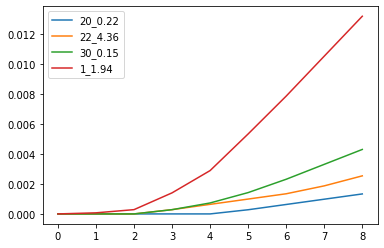

In [16]:
# for threshold in thresholds:
threshold = 0.8
for file in list(res.keys()):
    plt.plot(res[file][threshold], label=file.split('_')[0] + '_' + str(true_results[16][int(file.split('_')[0])]))
# plt.plot(res[file2][threshold], label=file2.split('_')[0])
plt.legend()

22_13:21:39_16-03-2020_38.png


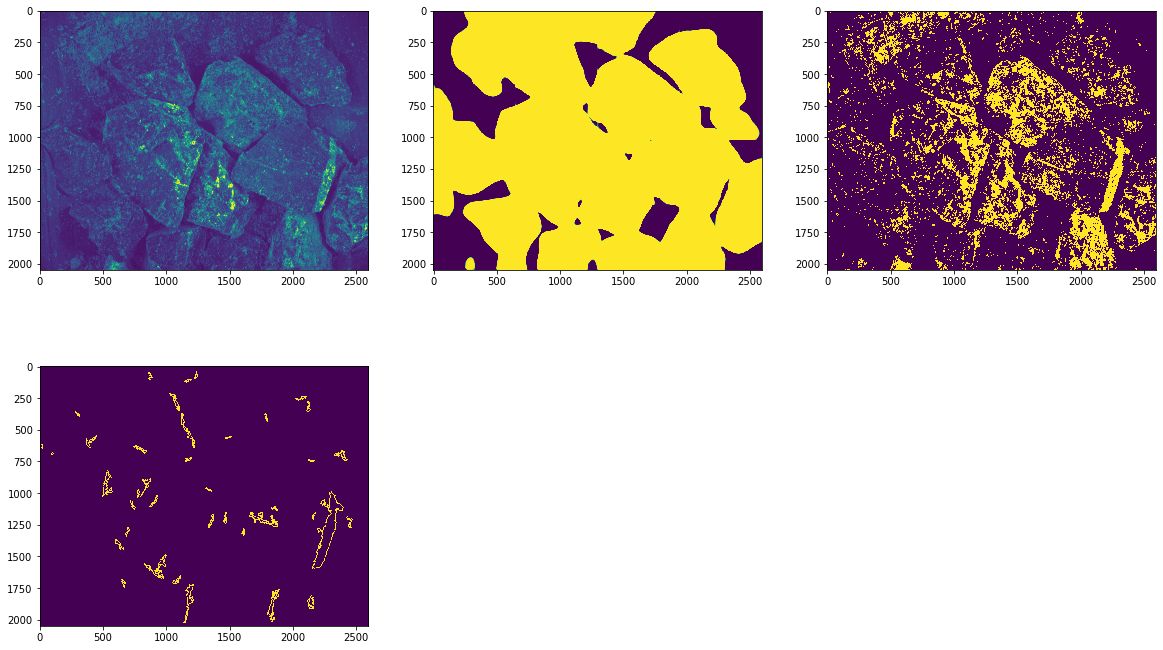

In [44]:
threshold = 0.4
min_area = 300
circle_coef = 0.2

i = np.random.randint(0, len(f))
f = [file for file in files_16 if file.split('_')[0] == '22']
print(f[i])
# np.random.randint(0,len(f))
img = cv2.imread(os.path.join(path_16, f[i]), cv2.IMREAD_UNCHANGED)
_, msk = big_image_predict(torch.load('stone_segmentation.pth'), img, crop_size = (img.shape[1] // 2, img.shape[0] // 2), inp_size = (448,448))
plt.figure(figsize=(20,12))
plt.subplot(231)
plt.imshow(img)
plt.subplot(232)
plt.imshow(msk)
plt.subplot(233)
clahe = cv2.createCLAHE(clipLimit=1.2, tileGridSize=(8,8))
img = clahe.apply(img).astype(float) / 255
# img = cv2.GaussianBlur(img, ksize=(25, 25), sigmaX=5)
plt.imshow(img > threshold)

plt.subplot(234)
cnts, hierarchy = cv2.findContours((img > threshold).astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
big_cnts = []
for cnt in cnts:
    area = cv2.contourArea(cnt)
    _, radius = cv2.minEnclosingCircle(cnt)
    if area > min_area and area / np.pi / radius ** 2 < circle_coef:
        big_cnts.append(cnt)
bw = np.zeros(img.shape, dtype=np.uint8)
cv2.drawContours(bw, big_cnts, -1, 255, 5, 1)
plt.imshow(bw * (msk > 0.95))

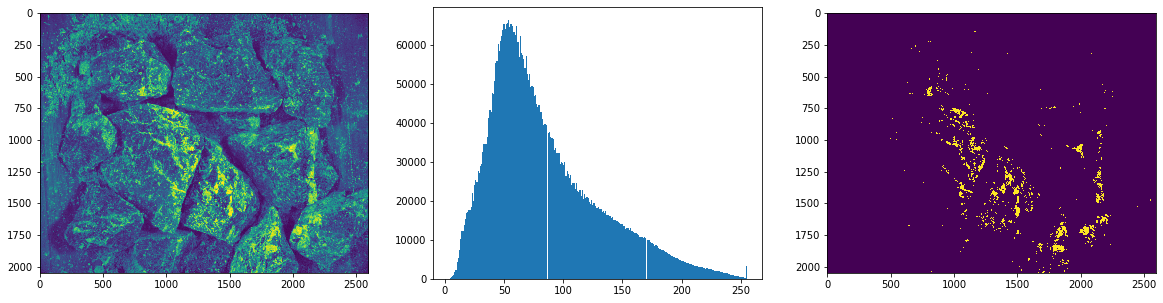

In [21]:
i = np.random.randint(0, len(f))
print(i)
f = [file for file in files_16 if file.split('_')[0] == '22']
img = cv2.imread(os.path.join(path_16, f[i]), cv2.IMREAD_UNCHANGED)
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
cl1 = clahe.apply(img)
plt.figure(figsize=(20,5))
plt.subplot(131)
plt.imshow(cl1)
plt.subplot(132)
plt.hist(cl1.ravel(), bins=255);
plt.subplot(133)
plt.imshow(cl1 > 0.8 * 255)

In [34]:
f[0]

'9_12:39:56_05-03-2020_0.png'

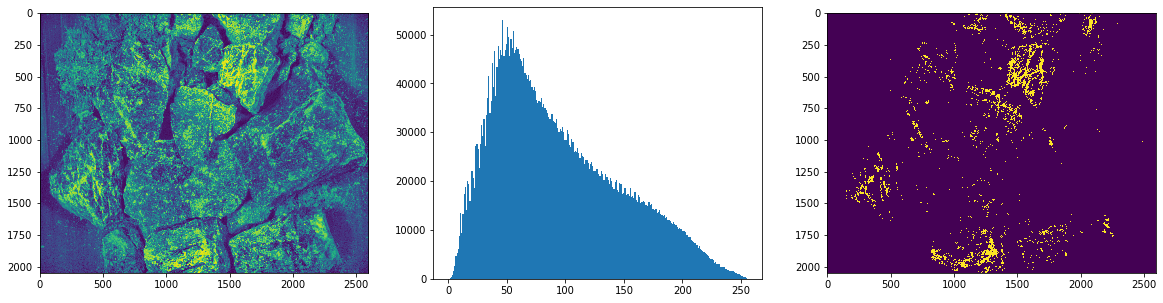

In [72]:
f = [file for file in files_05 if file.split('_')[0] == '7']
img = cv2.imread(os.path.join(path_05, f[0]), cv2.IMREAD_UNCHANGED)
clahe = cv2.createCLAHE(clipLimit=4.0, tileGridSize=(8,8))
cl1 = clahe.apply(img)
plt.figure(figsize=(20,5))
plt.subplot(131)
plt.imshow(cl1)
plt.subplot(132)
plt.hist(cl1.ravel(), bins=255);
plt.subplot(133)
plt.imshow(cl1 > 0.8 * 255)

In [75]:
lap = cv2.Laplacian(img, cv2.CV_64F)
lap.min()

-0.008613007103473236

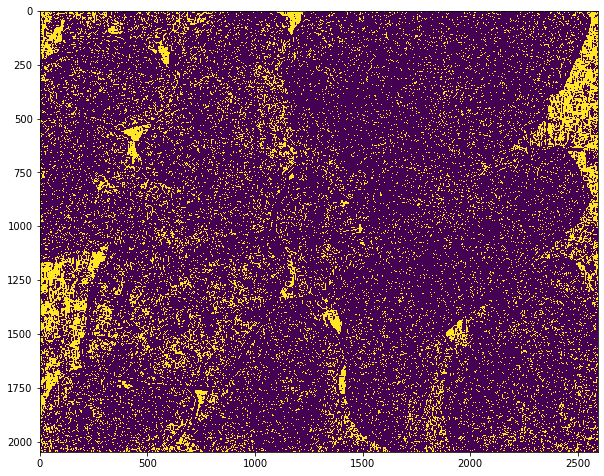

In [76]:
plt.figure(figsize=(10,10))
plt.imshow(abs(lap) < 1e-4)